In [117]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from mxlpy import Simulator, make_protocol, Model
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('..'))

from model import Li2021

here = Path("").absolute()

def save_fig(fig_num: str) -> Path:
    here = Path("").absolute()
    name = "Li2021"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

## Str Dictionary

In [118]:
pfd_str = "PPFD"
npq_str = "NPQ"
qared_str = "QA_red"
phipsii_str = "Phi2"
dphV_str = "delta_pH_inVolts"
deltapsi_str = "Dy"
pmf_str = "pmf"

# Figure 3

In [119]:
def create_fig3_sim(
    model: Model,
    pfd_str: str,
):
    light_100 = make_protocol([(20 * 60, {pfd_str: 100}), (5 * 60, {pfd_str: 0})])
    light_500 = make_protocol([(20 * 60, {pfd_str: 500}), (5 * 60, {pfd_str: 0})])
    
    param_dict = {
        "wt": {},
        "c": {"k_CLCE": 0},
        "v": {"k_VCCN1": 0},
        "k": {"k_KEA": 0},
        "cv": {"k_CLCE": 0, "k_VCCN1": 0},
        "ck": {"k_CLCE": 0, "k_KEA": 0},
        "vk": {"k_VCCN1": 0, "k_KEA": 0},
        "vck": {"k_CLCE": 0, "k_VCCN1": 0, "k_KEA": 0},
    }
    
    final_res_sim = {}
    final_res_stst = {}
    
    for gt, params in param_dict.items():
        model.update_parameters(params)
        
        res_sim = {}
        res_stst = {}
        for pfd, protocol in zip([500, 100], [light_500, light_100]):
            s = Simulator(model)
            s.simulate_protocol(protocol, time_points_per_step=100)
            res_sim[pfd] = s.get_result().unwrap_or_err().get_combined()
            
            # s = Simulator(model)
            # s.simulate_to_steady_state()
            # res_stst[pfd] = s.get_result().unwrap_or_err().get_combined()
        
        final_res_sim[gt] = pd.concat(res_sim, names=["PPFD"], axis=0)
        # final_res_stst[gt] = pd.concat(res_stst, names=["PPFD"], axis=0)
        
    final_res_sim = pd.concat(final_res_sim, names=["Genotype"], axis=0)
    # final_res_stst = pd.concat(final_res_stst, names=["Genotype"], axis=0)
    
    return final_res_sim, final_res_stst

def create_fig3_plot(
    res_sim: pd.DataFrame,
    res_stst: pd.DataFrame,
    npq_str: str,
    qared_str: str,
    phipsii_str: str,
    dphV_str: str,
):
    fig, axs = plt.subplot_mosaic(
        mosaic=[
            [x for x in ["qL", "PhiPSII", "NPQ", "pH", "DES"] for _ in range(7)],
            [x for x in ["c", "v", "k", "cv", "ck", "vk", "vck"] for _ in range(5)]
        ],
        figsize=(15, 5),
    )
    
    style_dict = {
        "100": {"color": "black"},
        "500": {"color": "red"},
    }
    
    for gt in res_sim.index.get_level_values("Genotype").unique():
        print(gt)
        gt_df_sim = res_sim.loc[gt]
        # gt_df_stst = res_stst.loc[gt]
        
        for pfd in gt_df_sim.index.get_level_values("PPFD").unique():
            if gt == "wt":
                axs["qL"].plot(1-gt_df_sim.loc[pfd, qared_str], **style_dict[str(pfd)])
                axs["PhiPSII"].plot(gt_df_sim.loc[pfd, phipsii_str], **style_dict[str(pfd)])
                axs["NPQ"].plot(gt_df_sim.loc[pfd, npq_str], **style_dict[str(pfd)])
            else:
                delta_npq = gt_df_sim.loc[pfd, npq_str] - res_sim.loc["wt"].loc[pfd, npq_str]
                axs[gt].plot(delta_npq, **style_dict[str(pfd)])
                
                # delta_deltapH = gt_df_stst.loc[pfd, dphV_str] - res_stst.loc["wt"].loc[pfd, dphV_str]
                # axs["pH"].plot(delta_deltapH, **style_dict[str(pfd)])
    
    for ax_str in ["qL", "PhiPSII", "NPQ", "c", "v", "k", "cv", "ck", "vk", "vck"]:
        axs[ax_str].set_xlabel("Time (min)")
        axs[ax_str].set_xlim(0*60, 25*60)
        axs[ax_str].set_xticks(np.linspace(0, 25, 6) * 60, labels=np.linspace(0, 25, 6, dtype=int))
    
    axs["qL"].set_ylim(0, 1.2)
    axs["qL"].set_title("qL")
    
    axs["PhiPSII"].set_ylim(0, 1.0)
    axs["PhiPSII"].set_title(r"$\Phi$II")
    
    axs["NPQ"].set_ylim(0, 2.5)
    axs["NPQ"].set_title("NPQ")
    
    for ax_str in ["c", "v", "k", "cv", "ck", "vk", "vck"]:
        axs[ax_str].set_ylim(-0.7, 0.7)
        axs[ax_str].set_yticks(np.linspace(-0.6, 0.6, 5))
        axs[ax_str].set_ylabel(r"$\Delta$NPQ")
        axs[ax_str].set_title(ax_str)
    
    plt.subplots_adjust(hspace=0.5, wspace=500)
    plt.tight_layout()
    return fig, axs


wt
c
v
k
cv
ck
vk
vck


/tmp/ipykernel_150724/4218864479.py:103: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


(<Figure size 1500x500 with 12 Axes>,
 {'qL': <Axes: label='qL', title={'center': 'qL'}, xlabel='Time (min)'>,
  'PhiPSII': <Axes: label='PhiPSII', title={'center': '$\\Phi$II'}, xlabel='Time (min)'>,
  'NPQ': <Axes: label='NPQ', title={'center': 'NPQ'}, xlabel='Time (min)'>,
  'pH': <Axes: label='pH'>,
  'DES': <Axes: label='DES'>,
  'c': <Axes: label='c', title={'center': 'c'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'v': <Axes: label='v', title={'center': 'v'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'k': <Axes: label='k', title={'center': 'k'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'cv': <Axes: label='cv', title={'center': 'cv'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'ck': <Axes: label='ck', title={'center': 'ck'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'vk': <Axes: label='vk', title={'center': 'vk'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>,
  'vck': <Axes: label='vck', title={'center': 'vck'}, xlabel='Time (min)', ylabel='$\\Delta$NPQ'>}

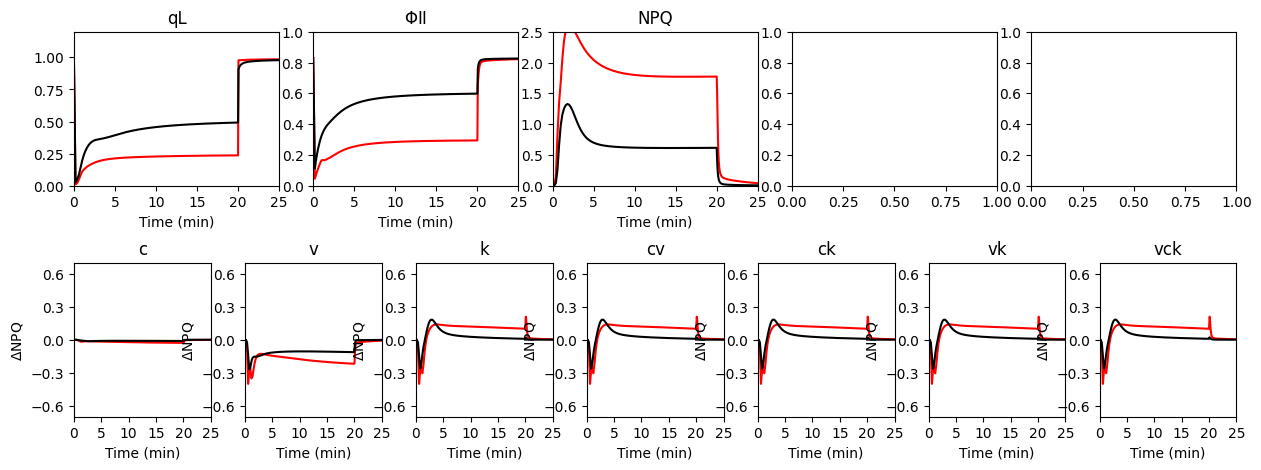

In [120]:
fig3_res_sim, fig3_res_stst = create_fig3_sim(
    model=Li2021(),
    pfd_str=pfd_str
)

create_fig3_plot(
    res_sim=fig3_res_sim,
    res_stst=fig3_res_stst,
    npq_str=npq_str,
    qared_str=qared_str,
    phipsii_str=phipsii_str,
    dphV_str=dphV_str
)

# Figure 4

In [157]:
def create_fig4_sim(
    model: Model,
    pfd_str: str,
):
    
    darktime = 1 * 60
    
    light_100 = make_protocol([(darktime, {pfd_str: 0}), (5 * 60, {pfd_str: 100})])
    light_500 = make_protocol([(darktime, {pfd_str: 0}), (5 * 60, {pfd_str: 500})])
    
    res = {}
    for prtc, pfd in zip([light_100, light_500], [100, 500]):
        s = Simulator(model)
        s.simulate_protocol(prtc, time_points_per_step=100)
        tmp_res = s.get_result().unwrap_or_err().get_combined()
        tmp_res.index = tmp_res.index - darktime
        tmp_res = tmp_res[tmp_res.index >= 0]
        res[pfd] = tmp_res
    
    return pd.concat(res, names=["PPFD"], axis=0)

def create_fig4_plot(
    res: pd.DataFrame,
    deltapsi_str: str,
    dphV_str: str,
    pmf_str: str,
):
    fig, axs = plt.subplot_mosaic(
        mosaic=[
            ["A_100", "A_500", "D"],
            ["B_100", "B_500", "D"],
            ["C_100", "C_500", "D"]
        ],
        figsize=(10,10),
        layout="constrained"
    )
    
    style_dict = {
        "deltapsi": {"color": "black"},
        "dpHV": {"color": "#0ef615"},
        "pmf": {"color": "#da56d7"}
    }
    
    for pfd in [100, 500]:
        axs[f"A_{pfd}"].set_title(f"{pfd} µmol m⁻² s⁻¹\nWT")
        axs[f"B_{pfd}"].set_title(f"VCCN1")
        axs[f"C_{pfd}"].set_title(f"KEA3")
        
        axs[f"A_{pfd}"].plot(res.loc[pfd][deltapsi_str], **style_dict["deltapsi"])
        dphV_twinx = axs[f"A_{pfd}"].twinx()
        dphV_twinx.plot(res.loc[pfd][dphV_str], **style_dict["dpHV"])
        dpmf_twinx = axs[f"A_{pfd}"].twinx()
        dpmf_twinx.plot(res.loc[pfd][pmf_str], **style_dict["pmf"])
        
        axs[f"A_{pfd}"].set_ylabel(r"$\Delta\Psi$(V)", color=style_dict["deltapsi"]["color"], rotation=0, ha="right")
        axs[f"A_{pfd}"].yaxis.set_label_coords(0, 1.03, transform=axs[f"A_{pfd}"].transAxes)
        # axs[f"A_{pfd}"].yaxis.set_label_position(0, -0.1)
        axs[f"A_{pfd}"].set_ylim(-0.005, 0.075)
        axs[f"A_{pfd}"].set_yticks(np.linspace(0, 0.06, 4))
        
        
        dphV_twinx.spines.left.set_position(("outward", 40))
        dphV_twinx.spines.left.set_visible(True)
        dphV_twinx.spines.left.set_color(style_dict["dpHV"]["color"])
        dphV_twinx.tick_params(axis="y", colors=style_dict["dpHV"]["color"])
        dphV_twinx.yaxis.tick_left()
        dphV_twinx.yaxis.set_label_position("left")
        dphV_twinx.set_ylabel(r"$\Delta$pH/V", color=style_dict["dpHV"]["color"], rotation=0, ha="right", va="center")
        dphV_twinx.yaxis.set_label_coords(-0.23, 1.05)
        dphV_twinx.set_ylim(0, 0.12)
        dphV_twinx.set_yticks(np.linspace(0, 0.12, 7))
        
        dpmf_twinx.spines.right.set_color(style_dict["pmf"]["color"])
        dpmf_twinx.tick_params(axis="y", colors=style_dict["pmf"]["color"])
        dpmf_twinx.set_ylabel(r"pmf/V", color=style_dict["pmf"]["color"], rotation=0, ha="left", va="center")
        dpmf_twinx.yaxis.set_label_coords(1, 1.05)
        dpmf_twinx.set_ylim(-0.005, 0.15)
        dpmf_twinx.set_yticks(np.linspace(0, 0.15, 4))

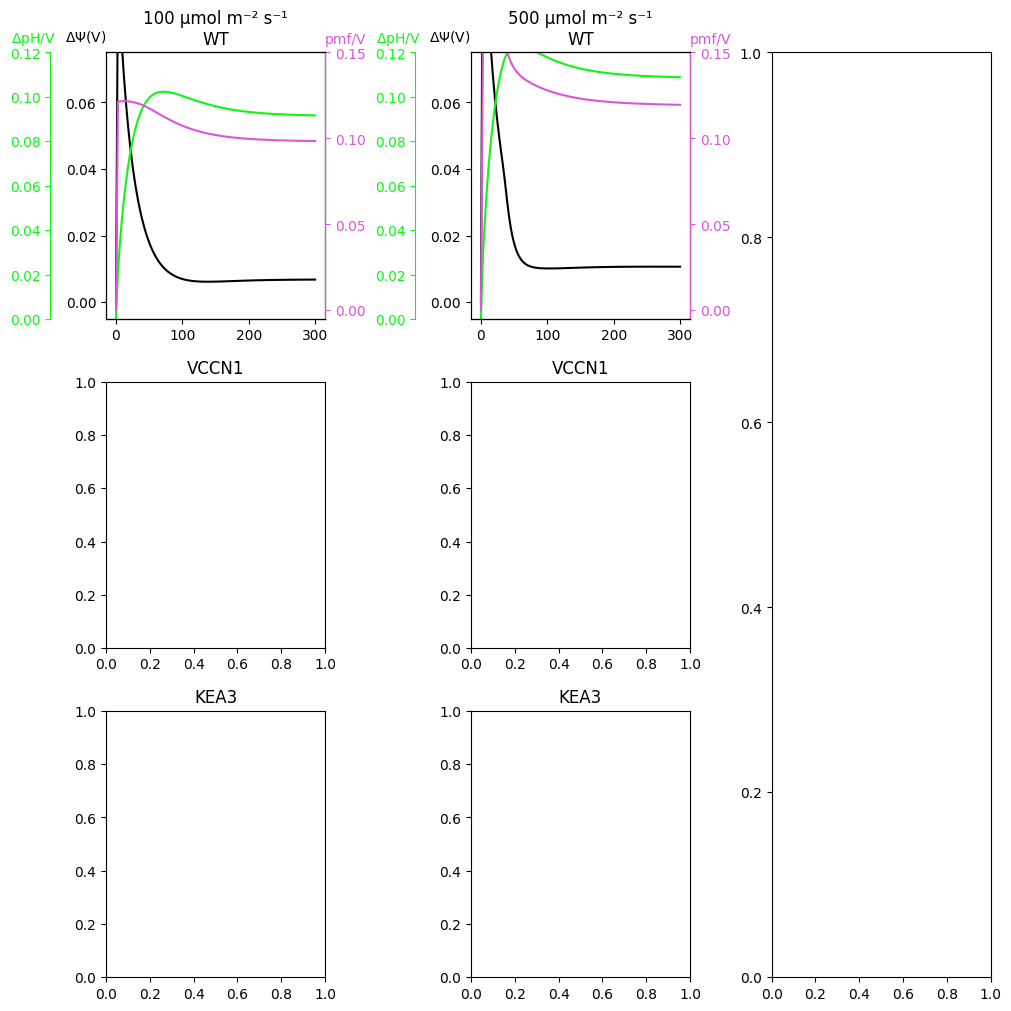

In [158]:
fig4_res = create_fig4_sim(
    model=Li2021(),
    pfd_str=pfd_str
)

create_fig4_plot(
    res=fig4_res,
    deltapsi_str=deltapsi_str,
    dphV_str=dphV_str,
    pmf_str=pmf_str
)